In [21]:
# make the screen bigger!
from IPython.display import display, HTML
display(HTML(data=""" <style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 85%; }
    div#maintoolbar-container { width: 99%; } </style> """))


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cond2sal import cond2sal  # Custom function that needs to be in directory "cond2sal.py"

# Tired of pink boxes?
pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib notebook

# set options 
pd.set_option('display.max_rows', 3500)  

# Function to convert resistivity in ohm-m to SpecCond in milisemens per cm
def ohmM_to_uSpcm(ohmMs):
    uSpcm = ohmMs*10000
    return uSpcm

#### unit conversions notes
1 ohm-m = 1 S/m  
1 S/m = 10000 uS/cm

https://www.cactus2000.de/uk/unit/masscnd.php
https://www.translatorscafe.com/unit-converter/en-US/electric-conductivity/12-10/microsiemens/meter-millisiemens/meter/

http://salinometry.com/pss-78/

<IPython.core.display.Javascript object>


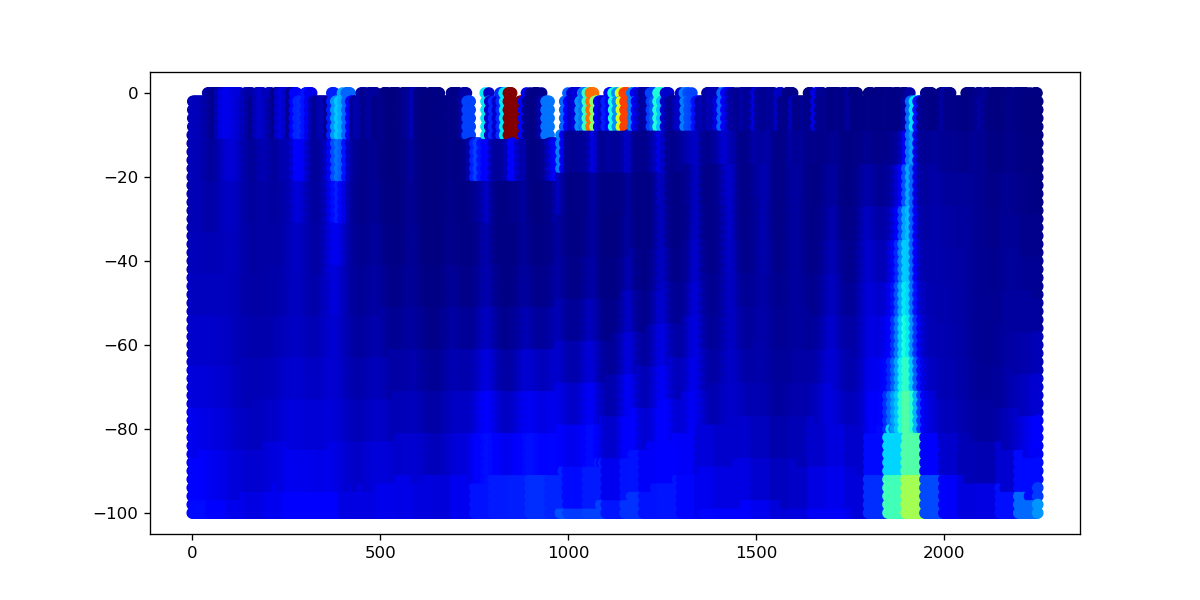

In [15]:
# Read in data
data = pd.read_csv("Line3a_Segment2.txt", sep = " ", index_col=False)

# Convert Resistivity values to salinity values 
data['Salinity'] = data['Resistivity'].apply(lambda x: cond2sal(ohmM_to_uSpcm(x)))

# Take coordinate data and turn into profile data starting at first point as endpoint
StartX = data['E'][0]
StartY = data['N'][0]
data["Xdistance"] = np.sqrt((data["E"]-StartX)**2 + (data["N"]-StartY)**2)
# flip depths proper way
data['D'] =  data['D']*-1

# cut out no data values
data2 = data[data['D'] < 1000]            # where depth is screwey
data3 = data[data['Resistivity'] < 6]     # and where resistivity is too high

# Plot profile 
fig, ax = plt.subplots(figsize =(10,5))
plt.scatter(data3['Xdistance'], data3['D'], c=data3['Salinity'], cmap=plt.cm.jet)

<IPython.core.display.Javascript object>


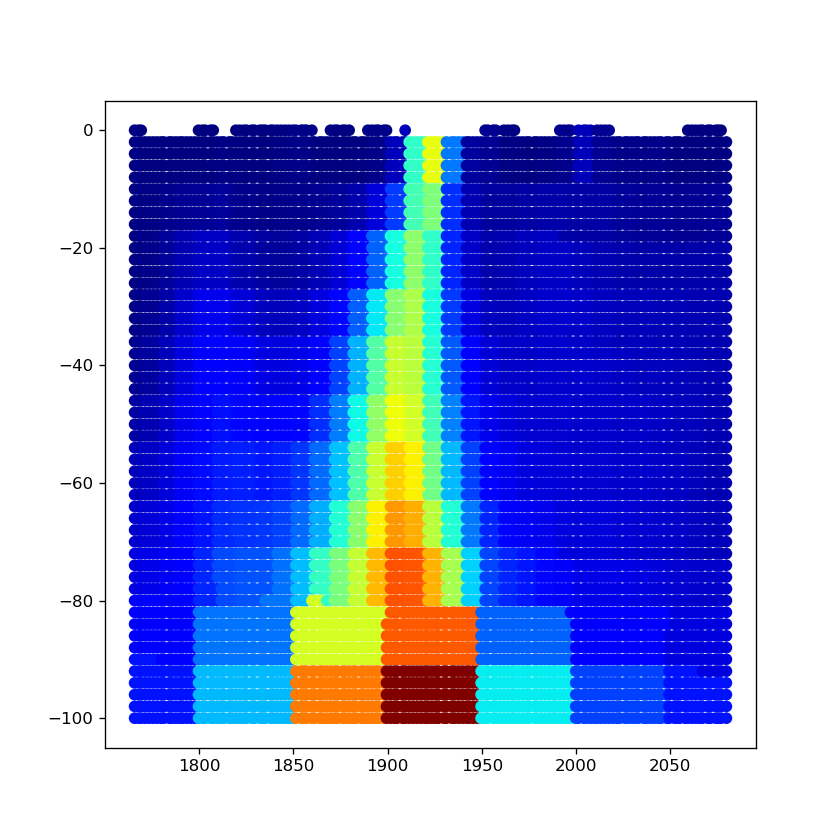

In [16]:

# pull out only the area to map (with the plume)
data3 = data3[(data3['Xdistance'] > 1765) & (data3['Xdistance'] < 2080) ]

fig, ax = plt.subplots(figsize =(7,7))
plt.scatter(data3['Xdistance'], data3['D'], c=data3['Salinity'], cmap=plt.cm.jet)

In [22]:
# Do some quantitative calculations by considering each point to be the center of a cell with boundaries half way between each point and its neighbors

# Prepare data
data3.reset_index(inplace=True, drop=True)
data4 = data3.copy()

data4["cell_height"] = 2.0    # each cell seems to be 2 m high
data4["cell_width"] = -999    # dummy column to fill later

Delta_dist_list = [1.4]   # starting list to append to, first cell edge is 1.4 m from first point
widthlist = [1.75]        # starting list to append to, first cell width is 1.7 m

# Data is evenly spaced in depth intervals but not in horizontal intervals, thus each "row" of data has equivalent but irregular horizontal spacing
tempframe = data3[data3['D'] == -50]  # This takes an arbitrary row, at depth -50 and makes a dataframe to be used to get the column widths
tempframe.reset_index(inplace=True, drop=True)   
    
    
for m in range(0, 157):                                                          # for each column
    Delta_dist = -tempframe['Xdistance'][m] + tempframe['Xdistance'][m+1]        # calculate the distance between each point
    Delta_dist_list.append(Delta_dist)                                           # record these distances
    Width = Delta_dist_list[m]/2 + Delta_dist_list[m+1]/2                        # Definte the cell width at each point as half the distance between it and the previous point and half dist to next point
    widthlist.append(Width)                                                      # record these widths

# set the values of the 'cell_width' col in the dataframe to the widths of each cell
for idx, j in enumerate(tempframe['Xdistance']):
    data4['cell_width'][data4['Xdistance'] == tempframe['Xdistance'][idx]] = widthlist[idx]

# Calculate area, unit meaning an assumed depth of 1 m
data4['cell_unit_area'] =data4['cell_height'] * data4['cell_width']

# Calculate the fraction of freshwater in each cell based on salnity
data4['cell_FW_fraction'] = data4['Salinity']/35.5  

# Calculate the volume of freshwater in each cell based on the 1 m unit width assumption
data4['cell_FW_volume_m3'] = data4['cell_FW_fraction']*data4['cell_unit_area']

# Stats on the whole profile
TOT_FW_Vol_m3 =  data4['cell_FW_volume_m3'].sum()
TOT_profile_Vol_m3 =  data4['cell_unit_area'].sum()
pct_FW = TOT_FW_Vol_m3/TOT_profile_Vol_m3*100

print("\n  the total volume of freshwater in profile is {:.0f}, of a total provile volumne of {:.0f}, thus the % of FW in the profile is {:.1f} \n".format(TOT_FW_Vol_m3, TOT_profile_Vol_m3, pct_FW))


  the total volume of freshwater in profile is 3742, of a total provile volumne of 31797, thus the % of FW in the profile is 11.8 

